<a href="https://colab.research.google.com/github/smnawfee/sharing-github/blob/main/wiki%2Bosm_kc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install bertopic

Load libraries

In [ ]:
from bertopic import BERTopic
import io
from google.colab import files
import pandas as pd
import geopandas as gpd
import nltk
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
import gensim
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

#Loading Data and merge them

In [ ]:
osm_uploaded = files.upload()
wiki_uploaded = files.upload()

Saving kc_osm_data2.csv to kc_osm_data2.csv


Saving kc_wiki_with_summary.csv to kc_wiki_with_summary.csv


In [ ]:
#read file
kc_wiki= pd.read_csv(io.BytesIO(wiki_uploaded['kc_wiki_with_summary.csv']))
kc_osm = pd.read_csv(io.BytesIO(osm_uploaded['kc_osm_data2.csv']), index_col=0)
#convert osm data to geopandas dataframe
import shapely.wkt
kc_osm['geometry.coordinates'] = gpd.GeoSeries.from_wkt(kc_osm["geometry.coordinates"])
kc_osm = gpd.GeoDataFrame(kc_osm, geometry = 'geometry.coordinates',
                                  crs="EPSG:4326")
kc_osm = kc_osm.rename(columns={'geometry.coordinates': 'geometry'})
#select certain columns from wiki data
kc_wiki = kc_wiki[["gt_page_id",
                   "gt_lat",
                   "gt_lon",
                   "geometry",
                   "page_title",
                   "page_summary"]]
#set geometry for wiki data
kc_wiki = gpd.GeoDataFrame(kc_wiki,
                           geometry=gpd.points_from_xy(kc_wiki.gt_lon,
                                                       kc_wiki.gt_lat),
                           crs="EPSG:4326")
#join dataframes
osm_wiki_kc = pd.concat([kc_osm, kc_wiki], ignore_index=True, sort=False)

Perform DBSCAN

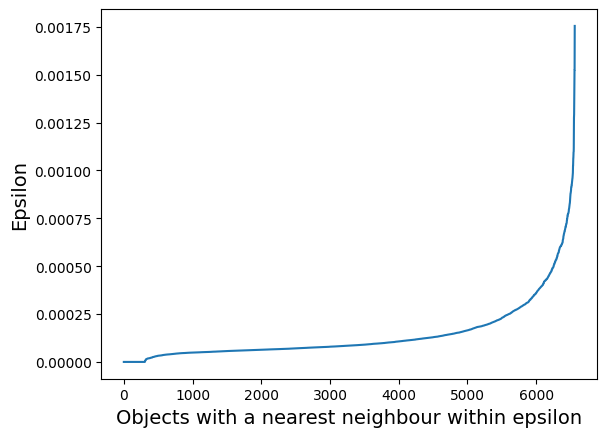

In [ ]:
from shapely.geometry import MultiPoint
#remove unnecessary values
osm_wiki_kc['lon'] = osm_wiki_kc['geometry'].x
osm_wiki_kc['lat'] = osm_wiki_kc['geometry'].y
kc_coords = osm_wiki_kc[['lon', 'lat']].to_numpy()
#finding the optimum epsilon
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
neighbors = NearestNeighbors(n_neighbors=60)
neighbors_fit = neighbors.fit(kc_coords)
distances, indices = neighbors_fit.kneighbors(kc_coords)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.xlabel('Objects with a nearest neighbour within epsilon', fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.plot(distances)

In [ ]:
#run dbscan
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#run dbscan clustering
dbscan = DBSCAN(eps=0.0006, min_samples=2)
kc_dbscan = dbscan.fit(kc_coords)
#get the labels of clustering
dbscan_labels = kc_dbscan.labels_
dbscan_labels
print('no. of clusters:', len(np.unique(dbscan_labels)))
print('no of noise:', np.sum(np.array(dbscan_labels) == -1, axis=0))
#add cluster labels to dataset
osm_wiki_kc['cluster'] = dbscan_labels

no. of clusters: 223
no of noise: 212


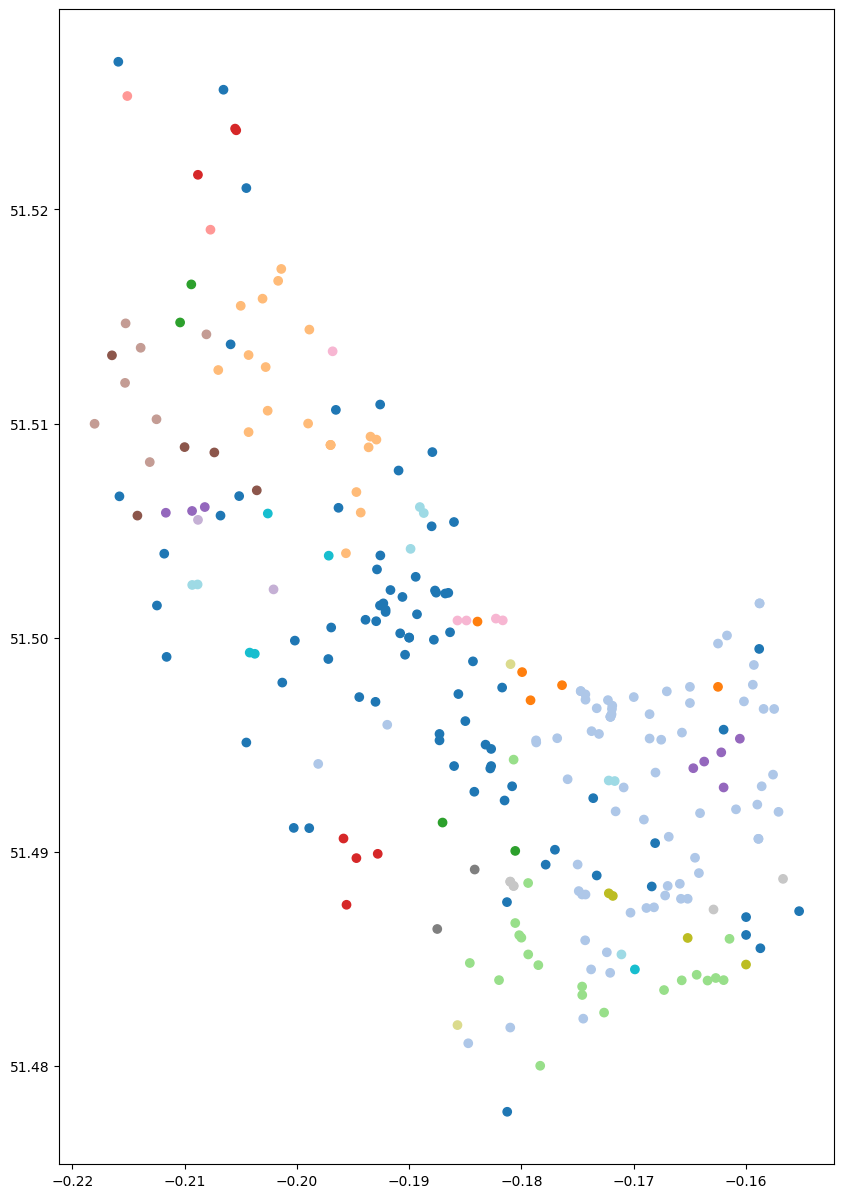

In [ ]:
import matplotlib.pyplot as plt
#plot dbscan
plt.figure(figsize=(10, 15))
plt.scatter(osm_wiki_kc['gt_lon'],
            osm_wiki_kc['gt_lat'],
            c=osm_wiki_kc['cluster'],
            cmap='tab20')


plt.show()

Create regions from dbscan clusters

In [ ]:
pip install geoZ
import geoz

#select certain columns
db_cl = osm_wiki_kc[["lat",
                   "lon",
                   "cluster"]]
remove = db_cl[db_cl['cluster'] == -1].index
db_cl = db_cl.drop(remove)
#rename columns
db_cl = db_cl.rename(columns={'lat': 'LATITUDE', 'lon': 'LONGITUDE'})

dataset=db_cl

map1 = geoz.convex_hull_plot(dataset[['LATITUDE','LONGITUDE']], dataset[['cluster']])            # This Function will return a Convex Hull map of the classes

#map2 = geoz.sklearn_plot(dataset[['LATITUDE','LONGITUDE']], dataset[['cluster']])                # This Function will return a map drawn using Scikit-Learn "DecisionBoundaryDisplay"

#map3 = geoz.mlx_plot(dataset[['LATITUDE','LONGITUDE']], dataset[['cluster']])

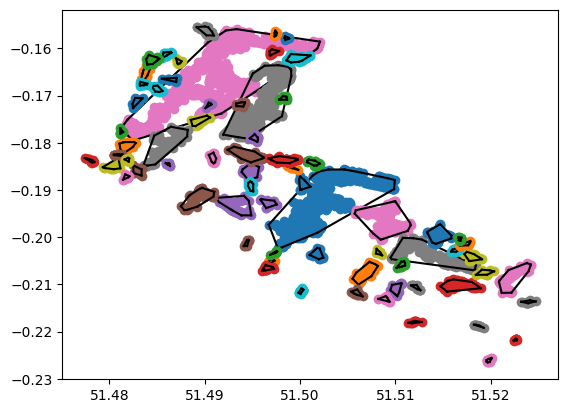

In [ ]:
#create convex hull
#Reference https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.ConvexHull.html
import scipy
import numpy
from scipy.spatial import ConvexHull, convex_hull_plot_2d
import matplotlib.pyplot as plt

#select only necessary column
db_cl = osm_wiki_kc[["lat",
                   "lon",
                   "cluster"]]
remove = db_cl[db_cl['cluster'] == -1].index
db_cl = db_cl.drop(remove)

#run convexhull for each clusters seperately
#create a list of convex hull
for i in range(0,70):
    cluster_i = db_cl.loc[db_cl['cluster']==i]
    db_cl_i = cluster_i[["lat", "lon"]].to_numpy()
    ch_i = ConvexHull(db_cl_i)
    plt.plot(db_cl_i[:, 0],db_cl_i[:, 1],  'o')
    for simplex in ch_i.simplices:
        ploted=plt.plot(db_cl_i[simplex, 0], db_cl_i[simplex, 1],'k-')



In [ ]:
#get tag list for each dbscan cluster as a list
osm_kc_dbscan_new = pd.DataFrame(osm_wiki_kc.groupby('cluster')['value'].apply(list))
osm_kc_dbscan_new.to_csv('osm_kc_dbscan_new')
files.download('osm_kc_dbscan.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Import BTM topics for OSM

In [ ]:
#import btm topics from osm_kc
osm_btm_uploaded = files.upload()


Saving osm_kc_btm.csv to osm_kc_btm.csv


In [ ]:
osm_btm= pd.read_csv(io.BytesIO(osm_btm_uploaded['osm_kc_btm.csv']))

In [ ]:
#Name the btm topics
def get_osm_topic_name(topic):
    if topic == 'V1':
        return 'Arts and Sports'
    elif topic == 'V2':
        return 'Greenery'
    elif topic == 'V3':
        return 'Restaurants, cafe and fast food'
    elif topic == 'V4':
        return 'Urban furniture'
    elif topic == 'V5':
        return 'Vehicle parking'
    elif topic == 'V6':
        return 'Estate agency and Healthcare'
    elif topic == 'V7':
        return 'High street shops'
    elif topic == 'V8':
        return 'Memorial'
    elif topic == 'V9':
        return 'Healthcare'
    else:
        return 'Service shops'

In [ ]:
osm_btm['Topic_Name_OSM'] = osm_btm['Topic'].apply(get_osm_topic_name)

In [ ]:
osm_btm

In [ ]:
#merge

osm_wiki_kc =  pd.merge(osm_wiki_kc, osm_btm, on = 'cluster')
osm_wiki_kc['Topic_Name_OSM'] = np.where(osm_wiki_kc.key == 'NaN',
                                         'NaN',
                                         osm_wiki_kc.Topic_Name_OSM)



In [ ]:
osm_wiki_kc

,geometry,properties.@osmId,key,value,gt_page_id,gt_lat,gt_lon,page_title,page_summary,lon,...,V3,V4,V5,V6,V7,V8,V9,V10,Topic,Topic_Name_OSM
0,POINT (-0.19315 51.50024),node/376496924,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN,-0.193151,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
1,POINT (-0.19301 51.49998),node/1291086772,properties.amenity,parking_entrance,NaN,NaN,NaN,NaN,NaN,-0.193006,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
2,POINT (-0.19332 51.50046),node/1291086833,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN,-0.193320,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
3,POINT (-0.19339 51.50059),node/1291086846,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN,-0.193388,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
4,POINT (-0.19659 51.49836),node/4499209132,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN,-0.196594,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6558,POINT (-0.20884 51.50248),NaN,NaN,NaN,38322460.0,51.502483,-0.208839,Debenham_House,Debenham House (or Peacock House) at 8 Addison...,-0.208839,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports
6559,POINT (-0.17170 51.49330),NaN,NaN,NaN,41023577.0,51.493300,-0.171700,"Pelham_Place,_London",Pelham Place is a street of Grade II* listed G...,-0.171700,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports
6560,POINT (-0.17223 51.49332),NaN,NaN,NaN,59864933.0,51.493325,-0.172231,"Park_House,_Kensington","Park House, at 7–11 Onslow Square, is a detach...",-0.172231,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports
6561,POINT (-0.18905 51.50610),NaN,NaN,NaN,58732278.0,51.506100,-0.189050,Ivy_Cottage,Ivy Cottage is a house in the grounds of Kensi...,-0.189050,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports


In [ ]:
#merge
osm_wiki_kc = pd.merge(osm_wiki_kc, osm_btm, on = 'cluster')

In [ ]:
osm_wiki_kc

,geometry,properties.@osmId,key,value,gt_page_id,gt_lat,gt_lon,page_title,page_summary,lon,...,V3,V4,V5,V6,V7,V8,V9,V10,Topic,Topic_Name_OSM
0,POINT (-0.19315 51.50024),node/376496924,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN,-0.193151,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
1,POINT (-0.19301 51.49998),node/1291086772,properties.amenity,parking_entrance,NaN,NaN,NaN,NaN,NaN,-0.193006,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
2,POINT (-0.19332 51.50046),node/1291086833,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN,-0.193320,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
3,POINT (-0.19339 51.50059),node/1291086846,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN,-0.193388,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
4,POINT (-0.19659 51.49836),node/4499209132,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN,-0.196594,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6558,POINT (-0.20884 51.50248),NaN,NaN,NaN,38322460.0,51.502483,-0.208839,Debenham_House,Debenham House (or Peacock House) at 8 Addison...,-0.208839,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports
6559,POINT (-0.17170 51.49330),NaN,NaN,NaN,41023577.0,51.493300,-0.171700,"Pelham_Place,_London",Pelham Place is a street of Grade II* listed G...,-0.171700,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports
6560,POINT (-0.17223 51.49332),NaN,NaN,NaN,59864933.0,51.493325,-0.172231,"Park_House,_Kensington","Park House, at 7–11 Onslow Square, is a detach...",-0.172231,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports
6561,POINT (-0.18905 51.50610),NaN,NaN,NaN,58732278.0,51.506100,-0.189050,Ivy_Cottage,Ivy Cottage is a house in the grounds of Kensi...,-0.189050,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports


Run Bertopic on wiki title

In [ ]:
#import string
#kc_wiki["page_title_processed"] = kc_wiki['page_title'].str.replace('[_(),]',' ')
#extract only wiki data first
summary_kc = kc_wiki['page_summary'].tolist()
summary_kc

In [ ]:
#run model
#extract embeddings
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
#reduce dimension
from umap import UMAP
umap_model = UMAP(n_neighbors=5, n_components=2, min_dist=0.0, metric='cosine')
#clustering
from hdbscan import HDBSCAN
hdbscan_model = HDBSCAN(min_cluster_size = 4, min_samples = 3,
                        gen_min_span_tree = True,
                        prediction_data = True)

#Tokenize topics
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(stop_words="english")
# Create topic representation
from bertopic.vectorizers import ClassTfidfTransformer
ctfidf_model = ClassTfidfTransformer()
topic_model = BERTopic( embedding_model=embedding_model,
                        umap_model=umap_model,
                        hdbscan_model=hdbscan_model,
                        vectorizer_model=cv,
                        ctfidf_model=ctfidf_model,
                        nr_topics=8,
                        language="english",
                        calculate_probabilities=True,
                        verbose=True)
topics, probs = topic_model.fit_transform(summary_kc)

2023-12-17 20:18:32,948 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/9 [00:00<?, ?it/s]

2023-12-17 20:18:56,397 - BERTopic - Embedding - Completed ✓
2023-12-17 20:18:56,402 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2023-12-17 20:19:11,830 - BERTopic - Dimensionality - Completed ✓
2023-12-17 20:19:11,833 - BERTopic - Cluster - Start clustering the reduced embeddings
2023-12-17 20:19:11,922 - BERTopic - Cluster - Completed ✓
2023-12-17 20:19:11,927 - BERTopic - Representation - Extracting topics from clusters using representation models.
2023-12-17 20:19:12,118 - BERTopic - Representation - Completed ✓
2023-12-17 20:19:12,124 - BERTopic - Topic reduction - Reducing number of topics
2023-12-17 20:19:12,248 - BERTopic - Topic reduction - Reduced number of topics from 29 to 8


In [ ]:
topic_model.visualize_barchart(top_n_topics = 8)

In [ ]:
topic_wiki = pd.DataFrame(topic_model.get_document_info(summary_kc))

In [ ]:
def get_topic_name(topic):
    if topic == 0:
        return 'Renowned roads and streets'
    elif topic == - 1:
        return 'Miscellaneous'
    elif topic == 1:
        return 'Diplomatic zone'
    elif topic == 2:
        return 'Boutique and fashion store'
    elif topic == 3:
        return 'Museum and exhibition'
    elif topic == 4:
        return 'Educational institutes'
    elif topic == 5:
        return 'Restaurants'
    else:
        return 'Miscellaneous'

In [ ]:
topic_wiki['Topic_Name_Wiki'] = topic_wiki['Topic'].apply(get_topic_name)

In [ ]:
# Merge two DataFrames by index
kc_wiki_topic = pd.merge(kc_wiki, topic_wiki, left_index=True, right_index=True)
kc_wiki_topic = gpd.GeoDataFrame(kc_wiki_topic, geometry = kc_wiki_topic["geometry"])
osm_wiki_kc = gpd.GeoDataFrame(osm_wiki_kc, geometry = osm_wiki_kc["geometry"])


In [ ]:
osm_wiki_kc

,geometry,properties.@osmId,key,value,gt_page_id,gt_lat,gt_lon,page_title,page_summary,lon,...,V3,V4,V5,V6,V7,V8,V9,V10,Topic,Topic_Name_OSM
0,POINT (-0.19315 51.50024),node/376496924,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN,-0.193151,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
1,POINT (-0.19301 51.49998),node/1291086772,properties.amenity,parking_entrance,NaN,NaN,NaN,NaN,NaN,-0.193006,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
2,POINT (-0.19332 51.50046),node/1291086833,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN,-0.193320,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
3,POINT (-0.19339 51.50059),node/1291086846,properties.amenity,dentist,NaN,NaN,NaN,NaN,NaN,-0.193388,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
4,POINT (-0.19659 51.49836),node/4499209132,properties.amenity,post_box,NaN,NaN,NaN,NaN,NaN,-0.196594,...,1.832204e-01,0.103611,0.098352,3.826239e-02,0.060768,0.028739,1.626244e-02,0.164155,V2,Greenery
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6558,POINT (-0.20884 51.50248),NaN,NaN,NaN,38322460.0,51.502483,-0.208839,Debenham_House,Debenham House (or Peacock House) at 8 Addison...,-0.208839,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports
6559,POINT (-0.17170 51.49330),NaN,NaN,NaN,41023577.0,51.493300,-0.171700,"Pelham_Place,_London",Pelham Place is a street of Grade II* listed G...,-0.171700,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports
6560,POINT (-0.17223 51.49332),NaN,NaN,NaN,59864933.0,51.493325,-0.172231,"Park_House,_Kensington","Park House, at 7–11 Onslow Square, is a detach...",-0.172231,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports
6561,POINT (-0.18905 51.50610),NaN,NaN,NaN,58732278.0,51.506100,-0.189050,Ivy_Cottage,Ivy Cottage is a house in the grounds of Kensi...,-0.189050,...,1.113821e-12,0.000088,0.001241,6.759561e-12,0.000090,0.000178,1.294399e-11,0.000090,V1,Arts and Sports


In [ ]:
#merge with dbscan
merged_gdf = gpd.sjoin(osm_wiki_kc, kc_wiki_topic, how="left")

In [ ]:
merged_gdf = merged_gdf.drop(columns=['gt_lat_left', 'gt_lon_left', 'page_title_right', 'page_summary_right', 'Document',
                                      'Name', 'Representation', 'Representative_Docs', 'Top_n_words', 'Representative_document', 'V1', 'V2',
                                      'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10'])

In [ ]:
merged_gdf

,geometry,properties.@osmId,key,value,gt_page_id_left,page_title_left,page_summary_left,lon,lat,cluster,Unnamed: 0,Topic_left,Topic_Name_OSM,index_right,gt_page_id_right,gt_lat_right,gt_lon_right,Topic_right,Probability,Topic_Name_Wiki
0,POINT (-0.19315 51.50024),node/376496924,properties.amenity,post_box,NaN,NaN,NaN,-0.193151,51.500241,0,0,V2,Greenery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (-0.19301 51.49998),node/1291086772,properties.amenity,parking_entrance,NaN,NaN,NaN,-0.193006,51.499975,0,0,V2,Greenery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (-0.19332 51.50046),node/1291086833,properties.amenity,dentist,NaN,NaN,NaN,-0.193320,51.500461,0,0,V2,Greenery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,POINT (-0.19339 51.50059),node/1291086846,properties.amenity,dentist,NaN,NaN,NaN,-0.193388,51.500591,0,0,V2,Greenery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,POINT (-0.19659 51.49836),node/4499209132,properties.amenity,post_box,NaN,NaN,NaN,-0.196594,51.498362,0,0,V2,Greenery,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6558,POINT (-0.20884 51.50248),NaN,NaN,NaN,38322460.0,Debenham_House,Debenham House (or Peacock House) at 8 Addison...,-0.208839,51.502483,219,219,V1,Arts and Sports,156.0,38322460.0,51.502483,-0.208839,0.0,1.000000,Renowned roads and streets
6559,POINT (-0.17170 51.49330),NaN,NaN,NaN,41023577.0,"Pelham_Place,_London",Pelham Place is a street of Grade II* listed G...,-0.171700,51.493300,220,220,V1,Arts and Sports,96.0,41023577.0,51.493300,-0.171700,0.0,1.000000,Renowned roads and streets
6560,POINT (-0.17223 51.49332),NaN,NaN,NaN,59864933.0,"Park_House,_Kensington","Park House, at 7–11 Onslow Square, is a detach...",-0.172231,51.493325,220,220,V1,Arts and Sports,153.0,59864933.0,51.493325,-0.172231,0.0,0.869969,Renowned roads and streets
6561,POINT (-0.18905 51.50610),NaN,NaN,NaN,58732278.0,Ivy_Cottage,Ivy Cottage is a house in the grounds of Kensi...,-0.189050,51.506100,221,221,V1,Arts and Sports,151.0,58732278.0,51.506100,-0.189050,0.0,0.812302,Renowned roads and streets


In [ ]:
#remove the noise cluster
#remove = merged_gdf[merged_gdf['cluster'] == -1].index
#merged_gdf2 = merged_gdf.drop(remove)

Organise clusters based on number of each OSM_BTM topics and Wiki BERTopic

In [ ]:
#pivot osm tags
merged_gdf3 = (
    pd.melt(merged_gdf,
            id_vars=['cluster'],
            value_vars = ['Topic_Name_OSM'])
      .pivot_table(columns='value',
                    aggfunc='count',
                    index='cluster',
                    values='value',
                    fill_value=0)
       )
merged_gdf3

In [ ]:
merged_gdf3.columns.name = None
merged_gdf3

In [ ]:
#pivot wiki title topics
merged_gdf4 = (
    pd.melt(merged_gdf,
            id_vars=['cluster'],
            value_vars = ['Topic_Name_Wiki'])
    .pivot_table(columns='value',
                    aggfunc='count',
                    index='cluster',
                    values='value',
                    fill_value=0)
)



In [ ]:
merged_gdf4.columns.name = None
merged_gdf4

In [ ]:
cluster_osm_wiki = pd.merge(merged_gdf3, merged_gdf4, on='cluster', how = 'left')
cluster_osm_wiki.fillna(0, inplace=True)
cluster_osm_wiki


,Arts and Sports,Estate agency and Healthcare,Greenery,Healthcare,High street shops,Memorial,"Restaurants, cafe and fast food",Service shops,Urban furniture,Vehicle parking,Boutique and fashion store,Diplomatic zone,Educational institutes,Miscellaneous,Museum and exhibition,Renowned roads and streets,Restaurants
cluster,,,,,,,,,,,,,,,,,
-1,0,0,0,0,0,0,0,0,0,212,1.0,5.0,1.0,5.0,0.0,23.0,1.0
0,0,0,961,0,0,0,0,0,0,0,4.0,0.0,1.0,1.0,2.0,19.0,1.0
1,0,0,0,0,0,0,0,0,0,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0,0,0,0,0,0,0,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,0,0,13,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,0,0,0,0,2,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
218,2,0,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
219,2,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [ ]:
cluster_osm_wiki.columns = cluster_osm_wiki.columns.astype(str)

In [ ]:
cluster_osm_wiki.columns.values

array(['Arts and Sports', 'Estate agency and Healthcare', 'Greenery',
       'Healthcare', 'High street shops', 'Memorial',
       'Restaurants, cafe and fast food', 'Service shops',
       'Urban furniture', 'Vehicle parking', 'Boutique and fashion store',
       'Diplomatic zone', 'Educational institutes', 'Miscellaneous',
       'Museum and exhibition', 'Renowned roads and streets',
       'Restaurants'], dtype=object)

In [ ]:
#summary stat for each column
cluster_osm_wiki.describe()

,Arts and Sports,Estate agency and Healthcare,Greenery,Healthcare,High street shops,Memorial,"Restaurants, cafe and fast food",Service shops,Urban furniture,Vehicle parking,Boutique and fashion store,Diplomatic zone,Educational institutes,Miscellaneous,Museum and exhibition,Renowned roads and streets,Restaurants
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000
mean,0.094170,0.035874,4.807175,0.130045,3.134529,0.170404,16.040359,0.017937,0.538117,4.569507,0.067265,0.089686,0.031390,0.188341,0.080717,0.793722,0.017937
std,0.515623,0.422951,64.376312,0.888436,25.867469,0.695949,115.019870,0.188978,3.284845,15.614251,0.553413,0.456220,0.174762,0.930198,1.014639,2.991362,0.133022
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,4.000000,6.000000,961.000000,8.000000,360.000000,6.000000,1527.000000,2.000000,41.000000,212.000000,7.000000,5.000000,1.000000,10.000000,15.000000,28.000000,1.000000


In [ ]:
#save as csv
cluster_osm_wiki.to_csv("cluster_osm_wiki.csv")

In [ ]:
#open csv
cluster_uploaded = files.upload()

Saving cluster_osm_wiki.csv to cluster_osm_wiki.csv


In [ ]:
cluster_osm_wiki= pd.read_csv(io.BytesIO(cluster_uploaded['cluster_osm_wiki.csv']))

In [ ]:
#standardise data
from sklearn.preprocessing import StandardScaler
sca = StandardScaler()
cow_std = sca.fit_transform(cluster_osm_wiki)
from sklearn.decomposition import PCA
#check for optimum number of components
#ref https://www.kdnuggets.com/2023/05/principal-component-analysis-pca-scikitlearn.html
import numpy as np
nums = np.arange(18)
variance_ratio = []
for num in nums:
  pca = PCA(n_components=num)
  pca.fit_transform(cow_std)
  variance_ratio.append(np.sum(pca.explained_variance_ratio_))


Text(0.5, 1.0, 'n_components vs. Explained Variance Ratio')

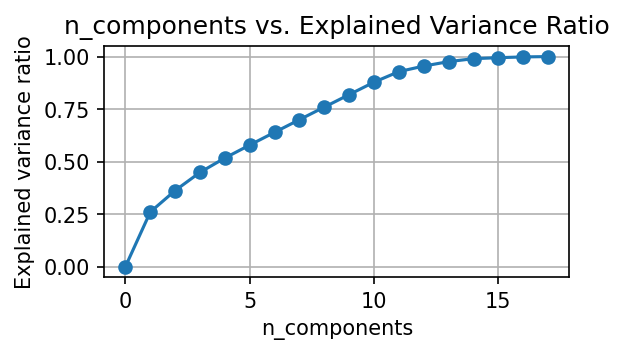

In [ ]:
#plot variance ratio for different component size
import matplotlib.pyplot as plt
plt.figure(figsize=(4,2),dpi=150)
plt.grid()
plt.plot(nums,variance_ratio,marker='o')
plt.xlabel('n_components')
plt.ylabel('Explained variance ratio')
plt.title('n_components vs. Explained Variance Ratio')

In [ ]:
#dimension reduction
pca = PCA(n_components=14)
cow_dr = pd.DataFrame(pca.fit_transform(cow_std))

In [ ]:
#standardize data (z-score normalisation)
new = (cluster_osm_wiki-cluster_osm_wiki.mean())/cluster_osm_wiki.std()
new

,Arts and Sports,Estate agency and Healthcare,Greenery,Healthcare,High street shops,Memorial,"Restaurants, cafe and fast food",Service shops,Urban furniture,Vehicle parking,Boutique and fashion store,Diplomatic zone,Educational institutes,Miscellaneous,Museum and exhibition,Renowned roads and streets,Restaurants
cluster,,,,,,,,,,,,,,,,,
-1,-0.182634,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,13.284691,1.685424,10.763047,5.542452,5.172724,-0.079553,7.423466,7.382715
0,-0.182634,-0.084819,14.853178,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,-0.292650,7.106331,-0.196585,5.542452,0.872566,1.891592,6.086283,7.382715
1,-0.182634,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,-0.164562,-0.121545,-0.196585,-0.179616,-0.202474,-0.079553,0.068958,-0.134844
2,-0.182634,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,-0.100518,-0.121545,-0.196585,-0.179616,-0.202474,-0.079553,-0.265338,-0.134844
3,-0.182634,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.026433,-0.094917,-0.163818,-0.292650,-0.121545,-0.196585,-0.179616,-0.202474,-0.079553,-0.265338,-0.134844
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,-0.182634,-0.084819,-0.074673,-0.146375,-0.043859,-0.244851,-0.139457,-0.094917,-0.163818,-0.292650,-0.121545,-0.196585,-0.179616,-0.202474,-0.079553,-0.265338,-0.134844
218,3.696171,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,-0.292650,-0.121545,1.995341,-0.179616,-0.202474,-0.079553,-0.265338,-0.134844
219,3.696171,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,-0.292650,-0.121545,-0.196585,-0.179616,-0.202474,-0.079553,0.403254,-0.134844


Run clustering on the resultant dataset

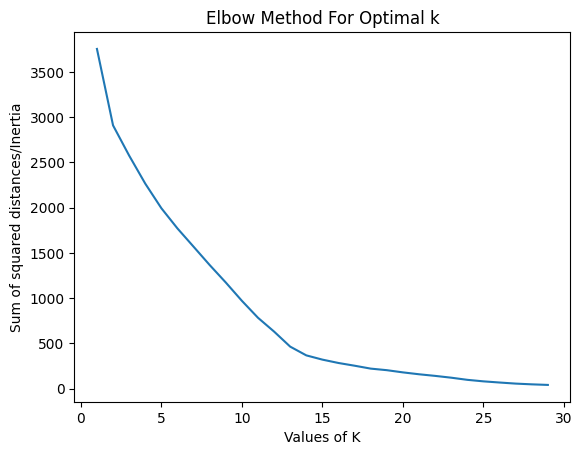

In [ ]:
x_array = cow_dr.values.tolist()
#determine optimum number of k for k-means clustering
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
Sum_of_squared_distances = []
K = range(1,30)
for cluster_no in K :
 kmeans = KMeans(n_clusters=cluster_no)
 kmeans.fit(x_array)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances)
plt.xlabel('Values of K')
plt.ylabel('Sum of squared distances/Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
#run k-means
kmeans2 = KMeans(n_clusters=13, random_state=0).fit(x_array)
label = kmeans2.fit_predict(x_array)
#join the cluster label to each dbscan cluster
import numpy as np
cluster_osm_wiki['k_means_cluster'] = np.array(label)
cluster_osm_wiki

In [ ]:
new['k_means_cluster'] = np.array(label)
new

,Arts and Sports,Estate agency and Healthcare,Greenery,Healthcare,High street shops,Memorial,"Restaurants, cafe and fast food",Service shops,Urban furniture,Vehicle parking,Boutique and fashion store,Diplomatic zone,Educational institutes,Miscellaneous,Museum and exhibition,Renowned roads and streets,Restaurants,k_means_cluster
cluster,,,,,,,,,,,,,,,,,,
-1,-0.182634,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,13.284691,1.685424,10.763047,5.542452,5.172724,-0.079553,7.423466,7.382715,4
0,-0.182634,-0.084819,14.853178,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,-0.292650,7.106331,-0.196585,5.542452,0.872566,1.891592,6.086283,7.382715,9
1,-0.182634,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,-0.164562,-0.121545,-0.196585,-0.179616,-0.202474,-0.079553,0.068958,-0.134844,0
2,-0.182634,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,-0.100518,-0.121545,-0.196585,-0.179616,-0.202474,-0.079553,-0.265338,-0.134844,0
3,-0.182634,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.026433,-0.094917,-0.163818,-0.292650,-0.121545,-0.196585,-0.179616,-0.202474,-0.079553,-0.265338,-0.134844,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,-0.182634,-0.084819,-0.074673,-0.146375,-0.043859,-0.244851,-0.139457,-0.094917,-0.163818,-0.292650,-0.121545,-0.196585,-0.179616,-0.202474,-0.079553,-0.265338,-0.134844,0
218,3.696171,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,-0.292650,-0.121545,1.995341,-0.179616,-0.202474,-0.079553,-0.265338,-0.134844,6
219,3.696171,-0.084819,-0.074673,-0.146375,-0.121176,-0.244851,-0.139457,-0.094917,-0.163818,-0.292650,-0.121545,-0.196585,-0.179616,-0.202474,-0.079553,0.403254,-0.134844,6


In [ ]:
import pandas as pd
K_clusters = cluster_osm_wiki.pivot_table(
                            index= 'k_means_cluster',
                            aggfunc="sum")

In [ ]:
K_clusters

,Arts and Sports,Boutique and fashion store,Diplomatic zone,Educational institutes,Estate agency and Healthcare,Greenery,Healthcare,High street shops,Memorial,Miscellaneous,Museum and exhibition,Renowned roads and streets,Restaurants,"Restaurants, cafe and fast food",Service shops,Urban furniture,Vehicle parking
k_means_cluster,,,,,,,,,,,,,,,,,
0,0,3.0,11.0,3.0,2,111,7,339,0,14.0,1.0,68.0,0.0,1028,0,46,807
1,0,7.0,1.0,0.0,0,0,0,0,0,10.0,0.0,28.0,0.0,1527,0,0,0
2,0,0.0,0.0,1.0,0,0,0,0,0,3.0,0.0,14.0,2.0,422,0,0,0
3,0,0.0,0.0,0.0,0,0,0,0,0,0.0,0.0,0.0,0.0,0,4,0,0
4,0,1.0,5.0,1.0,0,0,0,0,0,5.0,0.0,23.0,1.0,0,0,0,212
5,0,0.0,2.0,1.0,0,0,0,0,0,7.0,15.0,7.0,0.0,600,0,0,0
6,21,0.0,1.0,0.0,0,0,0,0,0,1.0,0.0,7.0,0.0,0,0,0,0
7,0,0.0,0.0,0.0,6,0,0,0,0,0.0,0.0,0.0,0.0,0,0,0,0
8,0,0.0,0.0,0.0,0,0,22,0,0,0.0,0.0,0.0,0.0,0,0,0,0


In [ ]:
K_clusters.pivot(columns= 'k_means_cluster')

KeyError: ignored

In [ ]:
K_clusters.to_csv('k_clusters.csv')
files.download('k_clusters.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
cluster_uploaded = files.upload()


Saving k_clusters.csv to k_clusters.csv


In [ ]:
#read file
k_clusters= pd.read_csv(io.BytesIO(cluster_uploaded['k_clusters.csv']))

In [ ]:
#standardize data (z-score normalisation)
new = (k_clusters-k_clusters.mean())/k_clusters.std()
new

,k_means_cluster,Arts and Sports,Boutique and fashion store,Diplomatic zone,Educational institutes,Estate agency and Healthcare,Greenery,Healthcare,High street shops,Memorial,Miscellaneous,Museum and exhibition,Renowned roads and streets,Restaurants,"Restaurants, cafe and fast food",Service shops,Urban furniture,Vehicle parking
0,-1.540658,-0.277350,0.841976,2.976775,2.806586,0.809858,0.107391,0.763437,2.172044,-0.277350,2.377039,-0.093038,2.897655,-0.488071,1.520366,-0.277350,1.581770,3.215038
1,-1.283881,-0.277350,2.666256,-0.169410,-0.613941,-0.359937,-0.310304,-0.357092,-0.409455,-0.277350,1.494139,-0.334936,0.766423,-0.488071,2.528092,-0.277350,-0.397097,-0.345875
2,-1.027105,-0.277350,-0.526235,-0.484028,0.526235,-0.359937,-0.310304,-0.357092,-0.409455,-0.277350,-0.050937,-0.334936,0.020493,2.684391,0.296554,-0.277350,-0.397097,-0.345875
3,-0.770329,-0.277350,-0.526235,-0.484028,-0.613941,-0.359937,-0.310304,-0.357092,-0.409455,-0.277350,-0.713112,-0.334936,-0.725438,-0.488071,-0.555671,3.328201,-0.397097,-0.345875
4,-0.513553,-0.277350,-0.070165,1.089064,0.526235,-0.359937,-0.310304,-0.357092,-0.409455,-0.277350,0.390514,-0.334936,0.500020,1.098160,-0.555671,-0.277350,-0.397097,0.589582
5,-0.256776,-0.277350,-0.526235,0.145209,0.526235,-0.359937,-0.310304,-0.357092,-0.409455,-0.277350,0.831964,3.293534,-0.352473,-0.488071,0.656024,-0.277350,-0.397097,-0.345875
6,0.000000,3.328201,-0.526235,-0.169410,-0.613941,-0.359937,-0.310304,-0.357092,-0.409455,-0.277350,-0.492387,-0.334936,-0.352473,-0.488071,-0.555671,-0.277350,-0.397097,-0.345875
7,0.256776,-0.277350,-0.526235,-0.484028,-0.613941,3.149449,-0.310304,-0.357092,-0.409455,-0.277350,-0.713112,-0.334936,-0.725438,-0.488071,-0.555671,-0.277350,-0.397097,-0.345875
8,0.513553,-0.277350,-0.526235,-0.484028,-0.613941,-0.359937,-0.310304,3.164570,-0.409455,-0.277350,-0.713112,-0.334936,-0.725438,-0.488071,-0.555671,-0.277350,-0.397097,-0.345875
9,0.770329,-0.277350,1.298046,-0.484028,0.526235,-0.359937,3.305949,-0.357092,-0.409455,-0.277350,-0.492387,0.148860,0.286896,1.098160,-0.555671,-0.277350,-0.397097,-0.345875


In [ ]:
import seaborn as sns

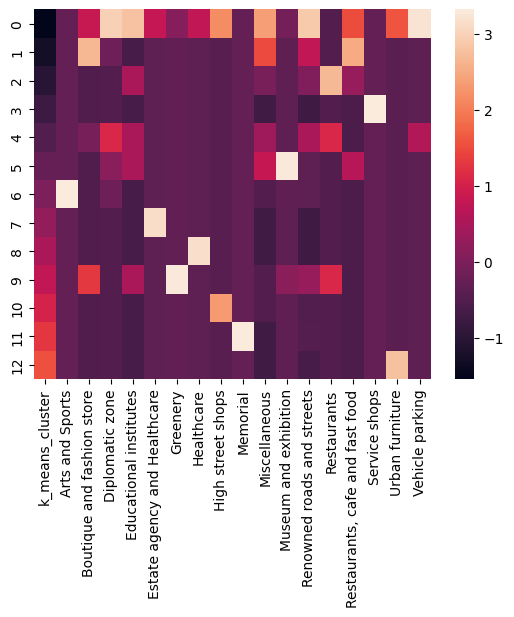

In [ ]:
k_heatmap = sns.heatmap(new)